The outcome of the tree clustering procedure is analyzed in this notebook. Specifically, we calculate intra-cluster coefficients of variation for bioclimatic conditions, tree density and estimated Aboveground Biomass Density (AGBD). We also calculate intra-cluster distances and homogeneity scores with respect to the ecoregion class. 

In [2]:
import pandas as pd
import geopandas as gpd

In [12]:
# This dataframe contains tree-level data and is used to estimate bioclimatic variation within each cluster.
trees_data = pd.read_csv("data/training/processing/trees_clusters_bioclimatic_predictors.csv")

# This dataframe contains cluster-level data and is used to estimate intr-cluster tree density variation and robustness of AGBD estimations for each cluster.
clusters_data = pd.read_csv("data/training/processing/clusters_agbd_mgha_bioclimatic_predictors.csv")

/tmp/ipykernel_1714252/193441182.py:2: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  trees_data = pd.read_csv("data/training/processing/trees_clusters_bioclimatic_predictors.csv")


Calculate coefficients of variation for tree density and climatic variables within each cluster and estimate average intra-cluster  variablity.

In [13]:
# First calculate the intra-cluster CV for each climatic variable and cluster.
subset_columns = ["bio{}".format(i) for i in range(1,20)]
subset_columns.append("gsl")
subset_columns.append("cluster")

df = trees_data[subset_columns].groupby("cluster").agg(["mean","std"]).reindex()
subset_columns.remove("cluster")

climatic_variation = pd.DataFrame()
for col in subset_columns:
    climatic_variation["{}_cv".format(col)]=df[col,"std"]/df[col,"mean"]*100

# Average CV of each climatic variable across clusters.
variable_level_average_climatic_variation = climatic_variation.mean(axis=0)
# Average CV across climatic variables for every cluster. 
cluster_level_average_climatic_variation = climatic_variation.mean(axis=1)

average_climatic_variation1 = variable_level_average_climatic_variation.mean()
average_climatic_variation2 = cluster_level_average_climatic_variation.mean()

print("Estimate of average intra-cluster climatic variability first aggregating by cluster then by variable:")
print("{} % \n".format(average_climatic_variation1))
print("Estimate of average intra-cluster climatic variability first aggregating by variable then by cluster:")
print("{} % \n".format(average_climatic_variation2))

# Calulate tree density CV
# TODO: correct column naming
clusters_data["td_cv"] = clusters_data["std_td"]/clusters_data["mean_td"]*100
# Average across clusters
average_tree_density_cv = clusters_data["td_cv"].mean()
print("Average intra-cluster tree density variability:")
print("{} %".format(average_tree_density_cv))


Estimate of average intra-cluster climatic variability first aggregating by cluster then by variable:
0.568883339567567 % 

Estimate of average intra-cluster climatic variability first aggregating by variable then by cluster:
0.568812213124226 % 

Average intra-cluster tree density variability:
10.382047218243741 %


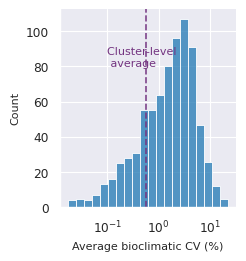

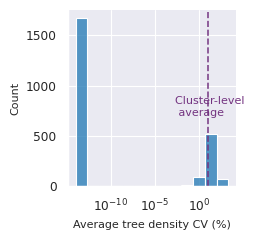

In [14]:
import seaborn as sns 
from matplotlib import pyplot as plt

sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8})
sns.set_style("darkgrid")
savedir = "./figures/"

g = sns.displot(cluster_level_average_climatic_variation,kind="hist",log_scale=True,height=2.5)
g.set(xlabel="Average bioclimatic CV (%)")
ax = g.axes
ax[0][0].axvline(x = average_climatic_variation2,color="#733380",alpha=0.9,linestyle='--')
ax[0][0].text(0.1, 80, "Cluster-level \n average", fontsize=8,color="#733380")

plt.savefig("{}clustering_bioclimatic_CV_300dpi.png".format(savedir),dpi=300,bbox_inches = "tight")
plt.savefig("{}clustering_bioclimatic_CV.svg".format(savedir))
plt.show()

g = sns.displot(clusters_data["td_cv"],kind="hist",log_scale=True,height=2.5)
g.set(xlabel="Average tree density CV (%)")
ax = g.axes
ax[0][0].axvline(x = average_tree_density_cv,color="#733380",alpha=0.9,linestyle='--')
ax[0][0].text(0.002, 700, "Cluster-level \n average", fontsize=8,color="#733380")

plt.savefig("{}clustering_treedensity_CV_300dpi.png".format(savedir),dpi=300,bbox_inches = "tight")
plt.savefig("{}clustering_treedensity_CV.svg".format(savedir))
plt.show()



Calculate intra-cluster distance.

In [6]:
import itertools 
from geoutils import haversine_distance_km_from_lat_lon

trees_data["lat,lon"] = list(zip(trees_data["latitude"], trees_data["longitude"]))

entries = []
nclusters = len(trees_data["cluster"].unique())
for i, clt in enumerate(trees_data["cluster"].unique()):

    if clt == -1:
        continue
    df = trees_data[ trees_data["cluster"] == clt].drop(columns="geometry")
    dist = 0
    n=0
    list_iter = itertools.combinations(df["lat,lon"], 2)
    for coord1,coord2 in itertools.combinations(df["lat,lon"], 2):
        dist+=haversine_distance_km_from_lat_lon(coord1,coord2)
        n+=1
    avg_dist = dist/n

    entry = {"cluster":clt,"avg_dist":avg_dist}
    entries.append(entry)
    
intracluster_distances = pd.DataFrame.from_dict(entries)
avg_distance = intracluster_distances["avg_dist"].mean()
print("Cluster-level average of average intra-cluster distances:")
print("{} km".format(avg_distance))
    

KeyboardInterrupt: 

Plot intra-cluster distance distribution.

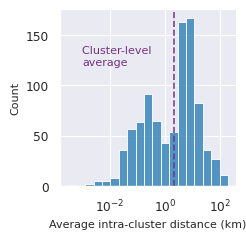

In [11]:

g = sns.displot(data = intracluster_distances, x="avg_dist", kind="hist",log_scale=True,height=2.5)
g.set(xlabel="Average intra-cluster distance (km)")
ax = g.axes
ax[0][0].axvline(x = avg_distance,color="#733380",alpha=0.9,linestyle='--')
ax[0][0].text(0.001, 120, "Cluster-level \naverage", fontsize=8,color="#733380")

plt.savefig("{}clustering_distance_CV_300dpi.png".format(savedir),dpi=300,bbox_inches = "tight")
plt.savefig("{}clustering_distance_CV.svg".format(savedir))
plt.show()

Calculate ecoregion class homogeneity.

In [64]:
from geoutils import add_feature
from data import fetch_ecoregion_data

ecoregions_file = fetch_ecoregion_data()

# Build the GeoDataFrame.
gdf = gpd.GeoDataFrame(
        trees_data,
        geometry= gpd.points_from_xy(x=trees_data.longitude, y=trees_data.latitude)
    )
gdf.crs = "EPSG:4326"

gdf = add_feature(gdf,"ECO_NAME",ecoregions_file,"Ecoregion") 

from sklearn.metrics.cluster import homogeneity_score

label_true = gdf["Ecoregion"]
label_pred = gdf["cluster"]

score = homogeneity_score(label_true,label_pred)

print("Ecoregion homogeneity score:", score)

Ecoregion homogeneity score: 0.9888188317938295


Calculate the average variation during the estimatino of AGBD in each cluster. This is the coefficient of variation of the estimated AGBD across replicas, where each replica corresponds to the sum of samples from the estimated AGB distribution within each cluster.  

In [66]:
clusters_data["agbd_cv"] = clusters_data["std_agbd"]/clusters_data["mean_agbd"]*100
average_agbd_cv = clusters_data["agbd_cv"].mean()

print("Average coefficient of variation of AGBD estimations:", average_agbd_cv, "%")

Average coefficient of variation of AGBD estimations: 1.1922599616275904 %
